In [58]:
%reset -f

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARMA
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
import datetime as dt
from pandas_datareader import data
from statsmodels.tsa.stattools import adfuller as ADF
import itertools
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_model import ARIMA

In [60]:
#读取数据
df = data.DataReader('BTC-USD','yahoo', dt.datetime(2014,9,16), dt.datetime.now())
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-04-26,55416.964844,53319.187500,54030.304688,55033.117188,4.944822e+10,55033.117188
2021-04-27,56227.207031,53887.917969,55036.636719,54824.703125,4.800057e+10,54824.703125
2021-04-28,55115.843750,52418.027344,54858.089844,53555.109375,4.608893e+10,53555.109375
2021-04-29,57900.718750,53129.601562,53568.664062,57750.175781,5.239593e+10,57750.175781
2021-05-01,58413.132812,57272.031250,57728.312500,57653.089844,5.135718e+10,57653.089844


In [61]:
# 将时间作为索引
df = df.reset_index()
df['Timestamp'] = pd.to_datetime(df['Date'],format='%D') 
df.index = df.Timestamp
df

,Date,High,Low,Open,Close,Volume,Adj Close,Timestamp
Timestamp,,,,,,,,
2014-09-16,2014-09-16,468.174011,452.421997,465.864014,457.334015,2.105680e+07,457.334015,2014-09-16
2014-09-17,2014-09-17,456.859985,413.104004,456.859985,424.440002,3.448320e+07,424.440002,2014-09-17
2014-09-18,2014-09-18,427.834991,384.532013,424.102997,394.795990,3.791970e+07,394.795990,2014-09-18
2014-09-19,2014-09-19,423.295990,389.882996,394.673004,408.903992,3.686360e+07,408.903992,2014-09-19
2014-09-20,2014-09-20,412.425995,393.181000,408.084991,398.821014,2.658010e+07,398.821014,2014-09-20
...,...,...,...,...,...,...,...,...
2021-04-26,2021-04-26,55416.964844,53319.187500,54030.304688,55033.117188,4.944822e+10,55033.117188,2021-04-26
2021-04-27,2021-04-27,56227.207031,53887.917969,55036.636719,54824.703125,4.800057e+10,54824.703125,2021-04-27
2021-04-28,2021-04-28,55115.843750,52418.027344,54858.089844,53555.109375,4.608893e+10,53555.109375,2021-04-28


In [62]:
df_bit=df[["Date","Close"]]
df_bit

,Date,Close
Timestamp,,
2014-09-16,2014-09-16,457.334015
2014-09-17,2014-09-17,424.440002
2014-09-18,2014-09-18,394.795990
2014-09-19,2014-09-19,408.903992
2014-09-20,2014-09-20,398.821014
...,...,...
2021-04-26,2021-04-26,55033.117188
2021-04-27,2021-04-27,54824.703125
2021-04-28,2021-04-28,53555.109375


In [63]:
# 按月，季度，年重采样
df_month = df_bit.resample('M').mean()
df_Q = df_bit.resample('Q-DEC').mean()
df_year = df_bit.resample('A-DEC').mean()

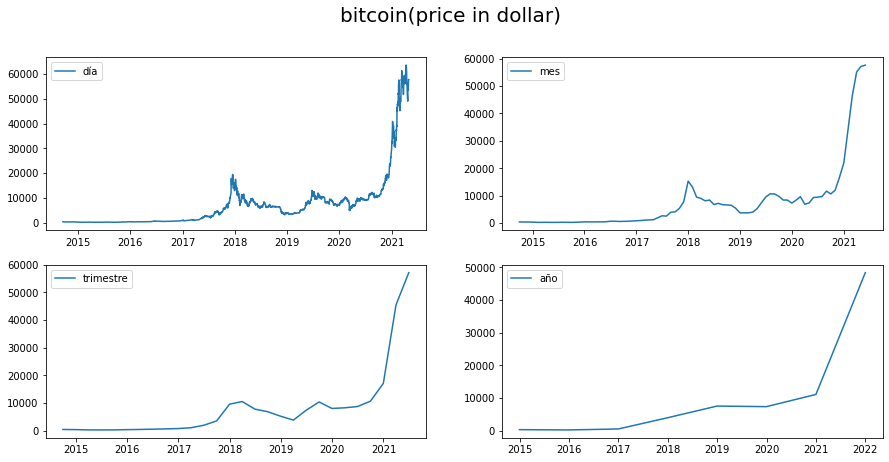

In [64]:
# 数据可视化
fig = plt.figure(figsize=[15, 7])
plt.suptitle('bitcoin(price in dollar)', fontsize=20)
plt.subplot(221)
plt.plot(df.Close, '-', label='día')
plt.legend()
plt.subplot(222)
plt.plot(df_month.Close, '-', label='mes')
plt.legend()
plt.subplot(223)
plt.plot(df_Q.Close, '-', label='trimestre')
plt.legend()
plt.subplot(224)
plt.plot(df_year.Close, '-', label='año')
plt.legend()
plt.show()

In [65]:
# Augmented Dick-Fuller test
# 如果序列平稳，就不存在单位根；否则，就会存在单位根。
# 看到 t-statistic 的值 0.112 要大于10%，所以无法拒绝原假设，另外，p-value的值也很大。
# 所以说不平稳，要进行差分
# 由于P值远大于0.05所以接受原假设，认为时间序列是白噪声的，即是随机产生的序列，不具有时间上的相关性。
# 但是，常见的时间序列一般都是非平稳的。必须通过差分后转化为平稳序列，才可以使用ARMA模型。

print('原始序列ADF检验结果', ADF(df_month['Close']))

原始序列ADF检验结果 (-0.28713708174548547, 0.9273064527803343, 1, 79, {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}, 1235.3374076160503)


In [66]:
# 差分法(不平稳处理),保存成新的列,1阶差分,dropna() 删除缺失值。实现平稳性。
# 计算相邻观测值之间的差值

diff = 0
adf = ADF(df_month['Close'])
while adf[1] >= 0.05:
    diff = diff + 1
    adf = ADF(df_month['Close'].diff(diff).dropna())
print('差分d次数为{}，p值为{}'.format(diff, adf[1]))
# 接下来看看1阶差分后该序列是否为白噪声

差分d次数为1，p值为0.0020622769019203514


In [67]:
print('白噪声检验结果', acorr_ljungbox(df_month['Close'].diff().dropna(), lags=1))

# 差分，将不平稳数据先变得平稳，再用ARMA模型

白噪声检验结果 (array([37.39761909]), array([9.63396648e-10]))


In [68]:
#choose best p,q
ps = range(0, 3)
qs = range(0, 3)
parameters = product(ps, qs)
parameters_list = list(parameters)

In [69]:
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        model = ARMA(df_month.Close,order=(param[0], param[1])).fit()
    except ValueError:
        print('parameter_error:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

parameter_error: (0, 2)
parameter_error: (1, 1)
parameter_error: (1, 2)


In [70]:
#输出最优模型
print('best_p_q', best_param)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print('optimized_model: ', best_model.summary())

best_p_q (2, 0)
optimized_model:                                ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                   81
Model:                     ARMA(2, 0)   Log Likelihood                -728.316
Method:                       css-mle   S.D. of innovations           1882.777
Date:                Sat, 01 May 2021   AIC                           1464.631
Time:                        11:19:02   BIC                           1474.209
Sample:                    09-30-2014   HQIC                          1468.474
                         - 05-31-2021                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.312e+04   1.01e+04      1.302      0.197   -6630.519    3.29e+04
ar.L1.Close     1.7039      0.082     20.748      0.000       1.543       1.865
ar.L2.Close   

In [72]:
# Prediction of bitcoin
df_month2 = df_month[['Close']]
#date_list = [datetime(2021, 4, 30)]
#future = pd.DataFrame(columns= df_month.columns)
df_month2 = pd.concat([df_month2])
df_month2['forecast'] = best_model.predict(start=0, end=91)


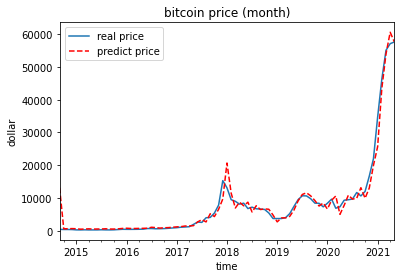

In [73]:

df_month2.Close.plot(label='real price')
df_month2.forecast.plot(color='r', ls='--', label='predict price')
plt.legend()
plt.title('bitcoin price (month)')
plt.xlabel('time')
plt.ylabel('dollar')
plt.show()

In [74]:
df_month2

,Close,forecast
Timestamp,,
2014-09-30,405.611265,13119.839013
2014-10-31,363.500002,562.269248
2014-11-30,366.099799,604.117734
2014-12-31,341.267871,639.084905
2015-01-31,248.782547,594.888449
...,...,...
2021-01-31,34703.053427,25665.184558
2021-02-28,46306.798968,43468.234614
2021-03-31,55126.064941,54015.923600


In [75]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score

In [80]:
error = r2_score(df_month2['forecast'], df_month['Close'])
error

0.9603120280160383